In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ampel.ztf.util.ZTFIdMapper import to_ztf_id
from astropy.time import Time
from sklearn import metrics

In [2]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=None, dpi=150, figsize=(5,4)):
    """
    Custom function to display a confusion matrix.
    """
    
    cm = metrics.confusion_matrix(
        y_true,
        y_pred,
        normalize=normalize
    )
    cm_df = pd.DataFrame(cm, columns=class_names, index=class_names)
    
    grid_kws = {"width_ratios": (.95, .05), "wspace": -.2}
    fig, (ax, cbar_ax) = plt.subplots(ncols=2, gridspec_kw=grid_kws, dpi=dpi, figsize=figsize)
    sns.heatmap(cm_df, ax=ax, cbar_ax=cbar_ax, cmap='Greens', annot=True, annot_kws={'fontsize': 20.0}, 
                fmt='d', square=True)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    cbar_ax.set_ylabel('Num. of Alerts', rotation=-90, labelpad=12.0)
    
    return fig, (ax, cbar_ax)

# Testing SNGuess as a Selection Tool

First we load a set of ZTF alerts over which SNGuess' unit was executed.

In [3]:
snguess = pd.read_csv('snguess_hu_tns_msip.csv')
snguess

,stockid,cut_pp,jd_det,jd_last,ndet,mag_det,mag_last,t_lc,rb_med,drb_med,...,slope_rise_g,slope_rise_r,col_det,col_last,col_peak,success,SNGuess,SNGuessBool,slope_fall_g,slope_fall_r
0,870833,0,2.459308e+06,2.459308e+06,1,19.805759,19.805759,0.000000,0.925714,1.000000,...,NaN,NaN,NaN,NaN,NaN,False,0.500000,NaN,NaN,NaN
1,870833,0,2.459308e+06,2.459308e+06,1,20.053623,20.053623,0.000000,0.888571,1.000000,...,NaN,NaN,NaN,NaN,NaN,False,0.500000,NaN,NaN,NaN
2,870833,0,2.459308e+06,2.459308e+06,2,19.805759,20.053623,0.046343,0.907143,1.000000,...,NaN,NaN,0.247864,0.247864,NaN,False,0.500000,NaN,NaN,NaN
3,870833,0,2.459308e+06,2.459308e+06,2,19.805759,20.053623,0.046343,0.907143,1.000000,...,NaN,NaN,0.247864,0.247864,NaN,True,-3.241392,0.0,NaN,NaN
4,877905,0,2.459320e+06,2.459320e+06,2,18.895201,19.179316,0.039549,0.856429,0.996535,...,NaN,NaN,0.284115,0.284115,NaN,False,0.500000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173397,628849937,0,2.459326e+06,2.459326e+06,1,16.497551,16.497551,0.000000,0.861429,0.999992,...,NaN,NaN,NaN,NaN,NaN,False,0.500000,NaN,NaN,NaN
173398,628849937,0,2.459324e+06,2.459326e+06,2,16.225618,16.497551,1.970058,0.872857,0.999989,...,NaN,NaN,NaN,NaN,NaN,False,0.500000,NaN,NaN,NaN
173399,628849937,0,2.459324e+06,2.459326e+06,3,16.225618,16.545849,2.010463,0.884286,0.999992,...,NaN,NaN,NaN,-0.048298,NaN,False,0.500000,NaN,NaN,NaN
173400,628849937,0,2.459326e+06,2.459332e+06,3,16.497551,18.155434,6.040359,0.861429,0.999992,...,NaN,NaN,-0.048298,NaN,-0.048298,False,0.500000,NaN,0.274468,NaN


We calculate the ZTF names from the stock IDs and we add them to the table as a new column.

In [4]:
snguess['ztfname'] = to_ztf_id(snguess['stockid'])

In [5]:
snguess.to_csv('data/snguess_hu_tns_msip_ztfname.csv', index_label=False)

In [6]:
print("%d alerts." % len(snguess))
print("%d candidates." % len(snguess.ztfname.unique()))
print("From %s..." % Time(snguess.jd_det.min(), format='jd').iso)
print("... to %s." % Time(snguess.jd_last.max(), format='jd').iso)

173402 alerts.
8969 candidates.
From 2020-10-08 05:03:39.997...
... to 2021-08-15 06:57:59.000.


Then, we load the transients picked up and classified by BTS. We obtain these by querying the BTS API @ CalTech (see `bts_transient_query.ipynb`).

In [7]:
bts_transients = pd.read_csv('data/bts_transients.csv', index_col='ZTFID')
bts_transients

,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
ZTFID,,,,,,,,,,,,,,
ZTF17aaahrni,AT2016dxt,05:21:41.58,-04:11:10.4,1155.90,g,17.1049,-,7.667,0.86,6.807,CV,-,-21.841960,0.827
ZTF17aaaikab,AT2019bgj,07:44:31.43,+48:26:30.4,1122.01,g,15.7679,-,>299.783,>294.2,5.583,CV,-,28.472792,0.155
ZTF17aaajnki,AT2022fmn,12:25:48.85,+33:32:48.7,462.05,r,17.8040,-,177.744,161.426,16.318,AGN,-,81.532942,0.047
ZTF17aaajowi,-,11:47:44.37,+14:34:10.4,1362.73,r,18.9963,-,>5.611,2.651,>2.96,-,-,70.564727,0.127
ZTF17aaanztg,AT2021abaw,10:04:06.59,-01:12:18.6,1501.02,r,18.3035,-,>14.737,>3,11.737,-,-,40.798120,0.210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22abbtzfm,SN2022rls,22:58:29.76,+40:25:42.6,1812.80,g,18.3256,-16.38,>2.02,>0,>2.02,SN IIb,0.01688,-17.526908,0.330
ZTF22abbzgcg,AT2022ryg,07:10:23.15,+17:07:35.6,1813.01,r,18.5319,-,>2.01,>0.01,>2,-,-,11.801316,0.658
ZTF22abbzibb,-,07:24:04.95,+15:20:40.8,1814.01,r,18.4657,-,>2,>1,>1,-,-,14.034312,0.240


We add a boolean field to the table of SNGuess detections that indicates whether its object was picked up by BTS

In [8]:
targeted_by_bts = pd.Series(True, index=bts_transients.index, name='targeted_by_bts')
snguess = snguess.merge(targeted_by_bts, how='left', left_on='ztfname', right_index=True).fillna(value={'targeted_by_bts':False})

In [9]:
print("%d alerts of candidates in ZTF list targeted by BTS" % len(snguess[snguess.targeted_by_bts]))
print("%d candidates in ZTF alert list targeted by BTS" % len(snguess[snguess.targeted_by_bts].ztfname.unique()))

41432 alerts of candidates in ZTF list targeted by BTS
907 candidates in ZTF alert list targeted by BTS


We add a column to the SNGuess table with the type that BTS assigned to the detection's source object, when appropriate.

In [10]:
snguess = pd.merge(snguess, bts_transients['type'], left_on=['ztfname'], how='left', right_index=True)

In [11]:
idx_typed = snguess.type.notna() & (snguess.type != '-')
print("%d of the alerts are labeled." % len(snguess[idx_typed]))
print("%d of the candidates are typed." % len(snguess[idx_typed].ztfname.unique()))

31579 of the alerts are labeled.
621 of the candidates are typed.


Next, we fix the default marginal score of SNGuess (replacing 0.5 with 0.0).

In [12]:
snguess.loc[snguess.SNGuessBool.isna(),'SNGuess'] = 0.0

We also add a field with probability-like SNGuess scores (with values from 0.0 to 1.0). We calculate it by applying the logistic function to the marginal scores.

In [13]:
snguess['SNGuessProb'] = 1 / (1 + np.exp(-snguess.SNGuess))

Please note that all of the alerts that have not been processed by SNGuess are assigned a default probability-like score of 0.5.

# Results Analysis

In [14]:
snguess_classified = snguess[snguess.SNGuessBool.notna()]

We define as:

1. Actual positive: any alert of a candidate targeted by BTS;
1. Actual negative: any alert of a candidate not targeted by BTS;
1. Predicted positive: any alert with an SNGuess score above threshold;
1. Predicted negative: any alert with an SNGuess score below threshold (must have a non-default score).

In [15]:
snguess_classified = snguess[snguess.SNGuessBool.notna()]
y_true = snguess_classified.targeted_by_bts
y_score = snguess_classified.SNGuessProb

Without setting a fixed classification threshold score, we can plot the ROC curve and calculate the ROC AUC metric. As a comparison, we will also plot the ROC curve for a classification by logistic regression using only `distnr_med` as an independent variable (see [logreg_results.ipynb](logreg_results.ipynb)).

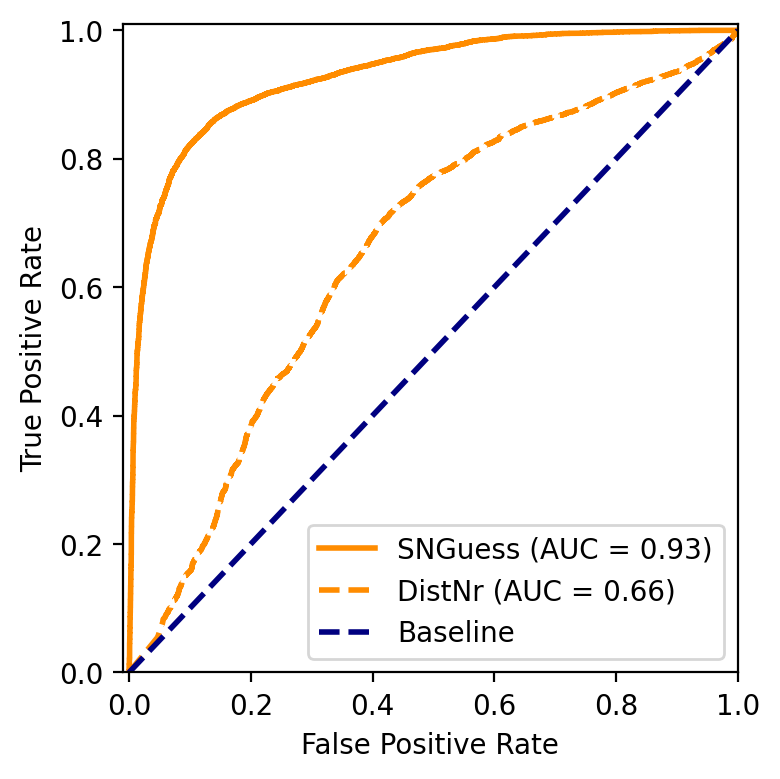

In [16]:
fpr, tpr, _ = metrics.roc_curve(y_true, y_score)
roc_auc = metrics.auc(fpr, tpr)
fig, ax = plt.subplots(dpi=200, figsize=(4,4))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="SNGuess (AUC = %0.2f)" % roc_auc,          # AUC: reflects performance from plot with a single score
)

logreg = np.load('data/logreg_distnr_fpr_tpr_auc.npz')
plt.plot(
    logreg['fpr'],
    logreg['tpr'],
    color="darkorange",
    lw=lw,
    linestyle="--",
    label="DistNr (AUC = %0.2f)" % logreg['auc'],
)

plt.plot([0, 1], [0, 1],                                 # Baseline performance (flipping a coin)
         color="navy", 
         lw=lw, 
         linestyle="--", 
         label='Baseline')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("plots/snguess_hutns_class_roc.pdf")

We can also plot the precision-recall curve.

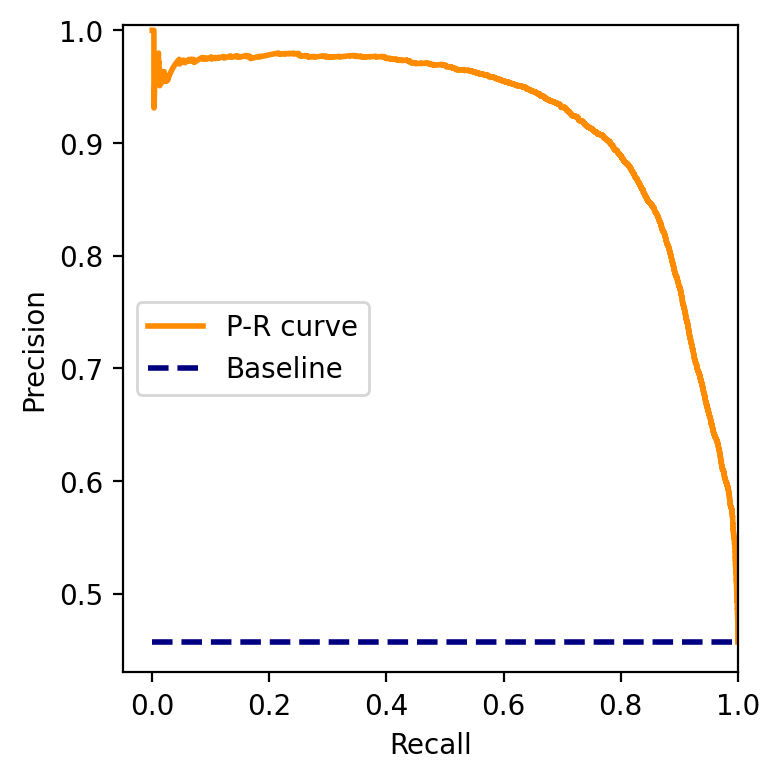

In [17]:
lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_true, y_score)
no_skill = np.sum(y_true) / len(y_true)
fig, ax = plt.subplots(dpi=200, figsize=(4,4))
plt.plot(lr_recall, lr_precision, linestyle='-', lw=lw, label='P-R curve', color="darkorange")       
plt.plot(                         # Plot baseline performance
    [0, 1], 
    [no_skill, no_skill], 
    linestyle='--', 
    lw=lw, 
    label='Baseline', 
    color='navy') 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(top=1.005)
plt.xlim(right=1.001)
plt.legend(loc='center left')
plt.tight_layout()
plt.savefig("plots/snguess_hutns_class_prerec.pdf")

If we explicitly set a probability-like threshold of 0.5 for a positive classification, then we can calculate other performance metrics.

In [18]:
y_true = snguess_classified.targeted_by_bts
y_pred = snguess_classified.SNGuessProb > 0.5

In [19]:
print("Precision (best=1.0, worse=0.0): %f" % metrics.precision_score(y_true, y_pred))
print("Recall (best=1.0, worse=0.0): %f" % metrics.recall_score(y_true, y_pred))
print("F1-score (best=1.0, worse=0.0): %f" % metrics.f1_score(y_true, y_pred))
print("MCC (perfect=+1.0, random=0.0, worse=-1.0): %f" % metrics.matthews_corrcoef(y_true, y_pred))

Precision (best=1.0, worse=0.0): 0.875981
Recall (best=1.0, worse=0.0): 0.818192
F1-score (best=1.0, worse=0.0): 0.846101
MCC (perfect=+1.0, random=0.0, worse=-1.0): 0.725737


We can also take a look to the confusion matrix of the classification.

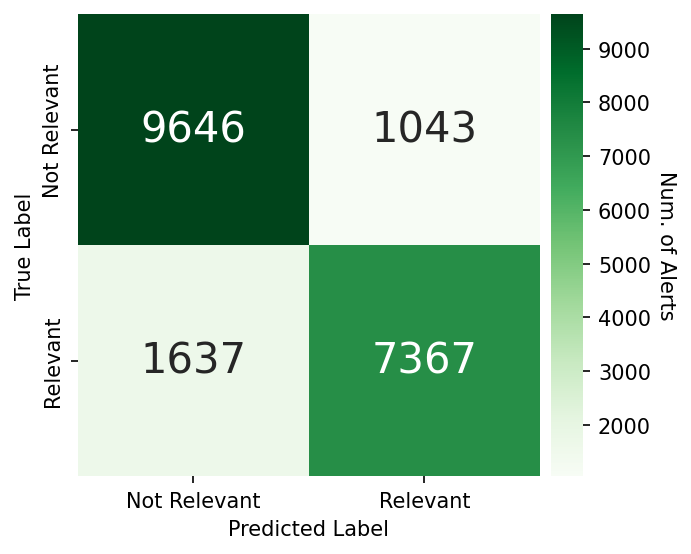

In [20]:
fig, axes = plot_confusion_matrix(y_true, y_pred, ['Not Relevant', 'Relevant'])
fig.savefig("plots/snguess_hutns_class_conf.pdf", bbox_inches='tight')

# Bias of the Selection

In [21]:
idx_typed = snguess_classified.type.notna()
total_class = len(snguess_classified[idx_typed])
print("Total:", total_class)
total_class_count = snguess_classified[idx_typed].type.value_counts()
total_class_count

Total: 9004


SN Ia         5029
-             1591
SN II         1245
SN IIn         238
SN Ia-91T      169
SN IIb         150
CV             123
SN Ic-BL       110
SN Iax          86
SN Ib           82
SN Ia-pec       49
SN Ic           40
SLSN-I          26
SN Ibn          24
SN Ib/c         12
Other           11
nova             6
AGN              3
SN II-pec        3
SN Ia-91bg       2
SN IIP           2
CV?              2
SN Ib-pec        1
Name: type, dtype: int64

In [22]:
snguess_classified[idx_typed].type.value_counts()['SN Ia'] / len(snguess_classified[idx_typed])

0.5585295424255886

In [23]:
idx_typed_and_selected = (snguess_classified.type.notna()) & (snguess_classified.SNGuessBool > 0.5)
selected_class = len(snguess_classified[idx_typed_and_selected])
print("Total:", selected_class)
selected_class_count = snguess_classified[idx_typed_and_selected].type.value_counts()
selected_class_count

Total: 7100


SN Ia         4294
SN II         1139
-              804
SN IIn         207
SN IIb         136
SN Ia-91T      124
SN Ic-BL       101
SN Ib           69
SN Iax          65
CV              48
SN Ic           37
SN Ia-pec       27
SN Ibn          19
SLSN-I          18
Other            9
SN Ia-91bg       1
SN Ib/c          1
SN II-pec        1
Name: type, dtype: int64

In [24]:
snguess_classified[idx_typed_and_selected].type.value_counts()['SN Ia'] / len(snguess_classified[idx_typed_and_selected])

0.6047887323943661

In [25]:
tot = total_class_count.drop('-') / total_class
tot = tot.iloc[:5]
tot

SN Ia        0.558530
SN II        0.138272
SN IIn       0.026433
SN Ia-91T    0.018769
SN IIb       0.016659
Name: type, dtype: float64

In [26]:
sel = selected_class_count[tot.index] / selected_class
sel

SN Ia        0.604789
SN II        0.160423
SN IIn       0.029155
SN Ia-91T    0.017465
SN IIb       0.019155
Name: type, dtype: float64

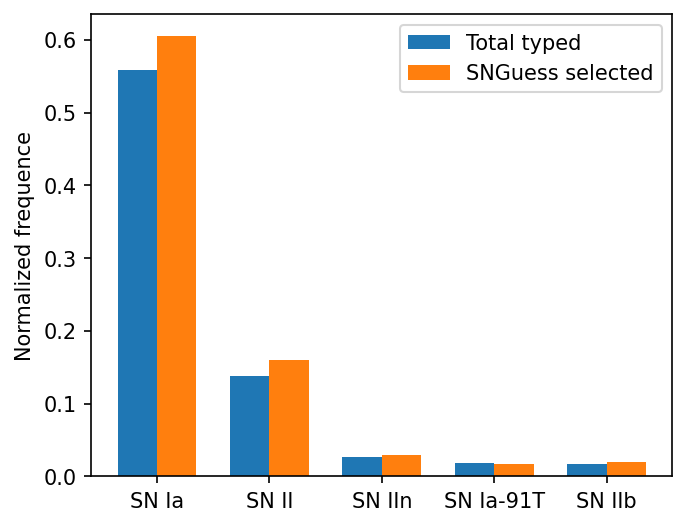

In [27]:
labels = sel.index.to_numpy()

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(dpi=150, figsize=(5,4))
rects1 = ax.bar(x - width/2, tot, width, label='Total typed')
rects2 = ax.bar(x + width/2, sel, width, label='SNGuess selected')

ax.set_ylabel('Normalized frequence')
ax.set_xticks(x, labels)
ax.legend()

fig.savefig("plots/snguess_hutns_class_type_bias.pdf", bbox_inches='tight')


# Precision Analysis

The main goal of SNGuess is achieving a high precision when recommending candidates for follow up observations. It is interesting to see how is the precision of SNGuess' recommendations across different kinds of alert.

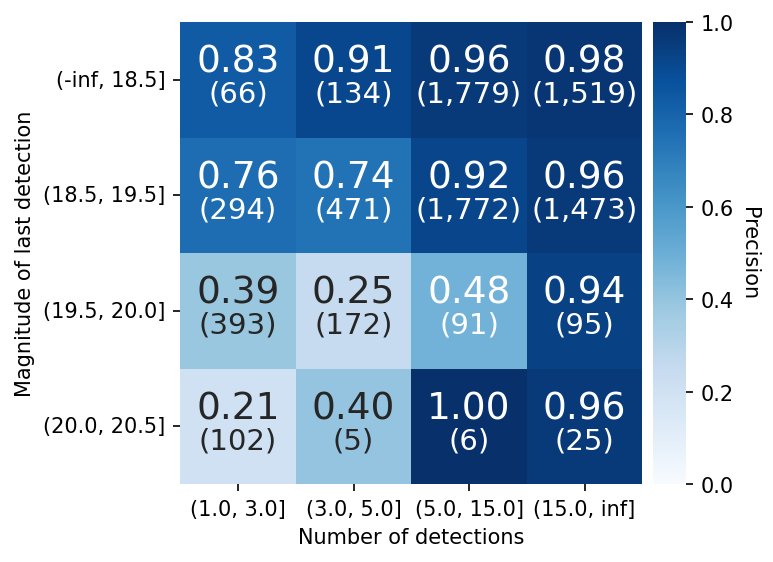

In [28]:
# Cut values in mag_last and ndet for bins
mag_last_cuts = pd.IntervalIndex.from_breaks([-float("inf"),18.5,19.5,20,20.5])
ndet_cuts = pd.IntervalIndex.from_breaks([1, 3, 5, 15, float('inf')])

# Matrix with counts for all selected by SNGuess
snguess_positive = snguess[snguess.SNGuessProb > 0.5]
positive_counts = pd.merge(
    pd.cut(snguess_positive.mag_last, mag_last_cuts),
    pd.cut(snguess_positive.ndet, ndet_cuts, right=False),
    left_index=True,
    right_index=True,
)\
.value_counts()\
.unstack(level=1)

# Matrix with counts for all selected by SNGuess and relevant
snguess_true_positive = snguess[(snguess.SNGuessProb > 0.5) & (snguess.targeted_by_bts)]
true_positive_counts = pd.merge(
    pd.cut(snguess_true_positive.mag_last, mag_last_cuts),
    pd.cut(snguess_true_positive.ndet, ndet_cuts, right=False),
    left_index=True,
    right_index=True,
)\
.value_counts()\
.unstack(level=1)

# Matrices for ratios (float values) and counts (strings  with integer numeric values between parentheses)
precisions = true_positive_counts / positive_counts
count_annotations = positive_counts.stack().map(int).map('({:,d})'.format).unstack()

# Plot binned matrix with precisions and counts
grid_kws = {"width_ratios": (.95, .05), "wspace": -.2}
fig, (ax, cbar_ax) = plt.subplots(ncols=2, gridspec_kw=grid_kws, dpi=150, figsize=(5,4))
sns.heatmap(precisions, ax=ax, cbar_ax=cbar_ax, cmap='Blues', annot=True, annot_kws={'va':'bottom', 'fontsize':18.0}, 
            fmt='.2f', vmin=0.0, vmax=1.0, square=True)
sns.heatmap(precisions, ax=ax, cmap='Blues', annot=count_annotations, annot_kws={'va':'top', 'fontsize':14.0}, 
            fmt='', cbar=False, vmin=0.0, vmax=1.0)
ax.set_xlabel('Number of detections')
ax.set_ylabel('Magnitude of last detection')
cbar_ax.set_ylabel('Precision', rotation=-90, labelpad=12.0)
fig.savefig("plots/snguess_hutns_prec.pdf", bbox_inches='tight')

# Classification metrics for different model groups

In [29]:
print(sum(snguess.SNGuessBool.notna()))
print(sum(snguess.SNGuessProb != 0.5))
print(len(snguess_classified))

19693
19693
19693


In [30]:
snguess_class_2 = snguess_classified[snguess_classified.ndet == 2]
snguess_class_2

,stockid,cut_pp,jd_det,jd_last,ndet,mag_det,mag_last,t_lc,rb_med,drb_med,...,col_peak,success,SNGuess,SNGuessBool,slope_fall_g,slope_fall_r,ztfname,targeted_by_bts,type,SNGuessProb
3,870833,0,2.459308e+06,2.459308e+06,2,19.805759,20.053623,0.046343,0.907143,1.000000,...,NaN,True,-3.241392,0.0,NaN,NaN,ZTF18aaadcnj,False,NaN,0.037637
100,1578658,0,2.459343e+06,2.459345e+06,2,19.515585,19.117289,1.944653,0.925714,0.998940,...,NaN,True,-1.222448,0.0,NaN,NaN,ZTF19aaafpyw,False,NaN,0.227506
102,1765586,0,2.459439e+06,2.459439e+06,2,20.247000,20.221991,0.022072,0.880714,0.999999,...,NaN,True,-7.272737,0.0,NaN,NaN,ZTF19aaaghgf,False,NaN,0.000694
137,4000609,0,2.459373e+06,2.459373e+06,2,20.232599,17.704908,0.106667,0.546429,0.994030,...,NaN,True,-6.397474,0.0,NaN,NaN,ZTF18aaaofww,False,NaN,0.001663
371,4611218,0,2.459378e+06,2.459380e+06,2,19.720116,19.874315,2.022894,0.691429,0.999995,...,NaN,True,-4.926879,0.0,NaN,NaN,ZTF19aaaqkir,False,NaN,0.007197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172590,554937217,0,2.459323e+06,2.459325e+06,2,19.996107,19.786255,1.956123,0.900714,0.998969,...,NaN,True,-3.912359,0.0,NaN,NaN,ZTF18acxxjbs,False,NaN,0.019601
172851,564652723,0,2.459349e+06,2.459351e+06,2,20.462000,20.426901,1.959942,0.690000,NaN,...,NaN,True,-2.510195,0.0,NaN,NaN,ZTF20aczfxih,False,NaN,0.075147
173211,581211250,0,2.459431e+06,2.459431e+06,2,19.350630,19.346863,0.045208,0.843571,0.999996,...,NaN,True,-3.475338,0.0,NaN,NaN,ZTF19adbmugl,False,NaN,0.030022
173215,585243505,0,2.459400e+06,2.459402e+06,2,19.896168,19.969467,2.016505,0.836429,0.999715,...,NaN,True,-1.634274,0.0,NaN,NaN,ZTF18adcbdbj,False,NaN,0.163246


In [31]:
snguess_class_ndet = snguess_classified[snguess_classified.ndet == 2]
y_true = snguess_class_ndet.targeted_by_bts
y_pred = snguess_class_ndet.SNGuessProb > 0.5
print("Precision (best=1.0, worse=0.0): %f" % metrics.precision_score(y_true, y_pred))
print("Recall (best=1.0, worse=0.0): %f" % metrics.recall_score(y_true, y_pred))
print("F1-score (best=1.0, worse=0.0): %f" % metrics.f1_score(y_true, y_pred))
print("MCC (perfect=+1.0, random=0.0, worse=-1.0): %f" % metrics.matthews_corrcoef(y_true, y_pred))

Precision (best=1.0, worse=0.0): 0.473418
Recall (best=1.0, worse=0.0): 0.537356
F1-score (best=1.0, worse=0.0): 0.503365
MCC (perfect=+1.0, random=0.0, worse=-1.0): 0.398990


In [32]:
snguess_class_ndet = snguess_classified[snguess_classified.ndet == 3]
y_true = snguess_class_ndet.targeted_by_bts
y_pred = snguess_class_ndet.SNGuessProb > 0.5
print("Precision (best=1.0, worse=0.0): %f" % metrics.precision_score(y_true, y_pred))
print("Recall (best=1.0, worse=0.0): %f" % metrics.recall_score(y_true, y_pred))
print("F1-score (best=1.0, worse=0.0): %f" % metrics.f1_score(y_true, y_pred))
print("MCC (perfect=+1.0, random=0.0, worse=-1.0): %f" % metrics.matthews_corrcoef(y_true, y_pred))

Precision (best=1.0, worse=0.0): 0.563830
Recall (best=1.0, worse=0.0): 0.781711
F1-score (best=1.0, worse=0.0): 0.655130
MCC (perfect=+1.0, random=0.0, worse=-1.0): 0.539428


In [33]:
snguess_class_ndet = snguess_classified[snguess_classified.ndet == 4]
y_true = snguess_class_ndet.targeted_by_bts
y_pred = snguess_class_ndet.SNGuessProb > 0.5
print("Precision (best=1.0, worse=0.0): %f" % metrics.precision_score(y_true, y_pred))
print("Recall (best=1.0, worse=0.0): %f" % metrics.recall_score(y_true, y_pred))
print("F1-score (best=1.0, worse=0.0): %f" % metrics.f1_score(y_true, y_pred))
print("MCC (perfect=+1.0, random=0.0, worse=-1.0): %f" % metrics.matthews_corrcoef(y_true, y_pred))

Precision (best=1.0, worse=0.0): 0.642105
Recall (best=1.0, worse=0.0): 0.827119
F1-score (best=1.0, worse=0.0): 0.722963
MCC (perfect=+1.0, random=0.0, worse=-1.0): 0.596858


In [34]:
snguess_class_ndet = snguess_classified[snguess_classified.ndet == 5]
y_true = snguess_class_ndet.targeted_by_bts
y_pred = snguess_class_ndet.SNGuessProb > 0.5
print("Precision (best=1.0, worse=0.0): %f" % metrics.precision_score(y_true, y_pred))
print("Recall (best=1.0, worse=0.0): %f" % metrics.recall_score(y_true, y_pred))
print("F1-score (best=1.0, worse=0.0): %f" % metrics.f1_score(y_true, y_pred))
print("MCC (perfect=+1.0, random=0.0, worse=-1.0): %f" % metrics.matthews_corrcoef(y_true, y_pred))

Precision (best=1.0, worse=0.0): 0.675743
Recall (best=1.0, worse=0.0): 0.877814
F1-score (best=1.0, worse=0.0): 0.763636
MCC (perfect=+1.0, random=0.0, worse=-1.0): 0.641817


In [35]:
snguess_class_ndet = snguess_classified[snguess_classified.ndet == 6]
y_true = snguess_class_ndet.targeted_by_bts
y_pred = snguess_class_ndet.SNGuessProb > 0.5
print("Precision (best=1.0, worse=0.0): %f" % metrics.precision_score(y_true, y_pred))
print("Recall (best=1.0, worse=0.0): %f" % metrics.recall_score(y_true, y_pred))
print("F1-score (best=1.0, worse=0.0): %f" % metrics.f1_score(y_true, y_pred))
print("MCC (perfect=+1.0, random=0.0, worse=-1.0): %f" % metrics.matthews_corrcoef(y_true, y_pred))

Precision (best=1.0, worse=0.0): 0.671018
Recall (best=1.0, worse=0.0): 0.898601
F1-score (best=1.0, worse=0.0): 0.768311
MCC (perfect=+1.0, random=0.0, worse=-1.0): 0.617176


In [36]:
snguess_class_ndet = snguess_classified[snguess_classified.ndet >= 7]
y_true = snguess_class_ndet.targeted_by_bts
y_pred = snguess_class_ndet.SNGuessProb > 0.5
print("Precision (best=1.0, worse=0.0): %f" % metrics.precision_score(y_true, y_pred))
print("Recall (best=1.0, worse=0.0): %f" % metrics.recall_score(y_true, y_pred))
print("F1-score (best=1.0, worse=0.0): %f" % metrics.f1_score(y_true, y_pred))
print("MCC (perfect=+1.0, random=0.0, worse=-1.0): %f" % metrics.matthews_corrcoef(y_true, y_pred))

Precision (best=1.0, worse=0.0): 0.962841
Recall (best=1.0, worse=0.0): 0.827071
F1-score (best=1.0, worse=0.0): 0.889807
MCC (perfect=+1.0, random=0.0, worse=-1.0): 0.783622
